# Model Notebook

This notebook will contain continued model iterations with more in-depth cross-validation and hyperparameter tuning. After experimenting with feature engineering in the previous notebook (06_feature_engineering), I found the best feature combination to be the current weather conditions with the addition of week of year and hour of day. These will be the features I move forward with. In this notebook I intend to create a custom imputation object similar to IterativeImputer but include PCA to account for collinearity between features. I also want to try using time series analysis to forecast these energy predictions, specifically the SARIMAX model so I am able to include weather conditions as exogenous variables.

This notebook will also contain continued data exploration and a more visuals to be used for my presentation.

## Plan:
- Import and format dataframe
- Explore current features
- Model iterations
- Custom imputer
- Experiment with imputation during iterations

In [1]:
# Imports

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Model selection & cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Use functions from .py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.data_gathering as dg

## Import and format dataframe

In [2]:
energy = dg.energy_data()
weather = dg.weather_data()

The base dataframes are imported, next I will add the week and hour column to the energy dataframe.

In [3]:
energy['week'] = energy.index.week
energy['hour'] = energy.index.hour

Now I can impute the missing data in weather using IterativeImputer and aggregate the weather dataframe to hourly format and combine it with the energy dataframe.

In [4]:
weather = weather.astype(float)

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [6]:
imp = IterativeImputer(random_state=42)

In [7]:
weather_imputed = imp.fit_transform(weather)

In [8]:
weather_df = pd.DataFrame(index=weather.index, columns=weather.columns, data=weather_imputed)

In [9]:
weather_hourly = weather_df.resample('H').mean()

To make sure everything if formatted correctly I will add a time column to the weather_hourly dataframe. Once I am sure everything is set up correctly I can drop that column

In [10]:
weather_hourly['time'] = weather_hourly.index

In [11]:
base_df = pd.concat([energy, weather_hourly.shift(3)], axis=1)

In [12]:
base_df.head()

,nexus_meter,week,hour,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage,time
DATE,,,,,,,,,,,,,,
2018-01-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2018-01-29 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2018-01-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2018-01-29 03:00:00,NaN,NaN,NaN,30.3425,28.0,30.0,92.25,29.5125,5.75,14.25,327.5,0.017317,80.0,2018-01-29 00:00:00
2018-01-29 04:00:00,NaN,NaN,NaN,30.3400,28.0,30.0,92.00,29.5100,3.00,10.00,340.0,0.000000,80.0,2018-01-29 01:00:00


The weather lag is correct, now I can drop the first 24 rows since there is no energy data for the first day, I will also drop the time column because it was just used to make sure the dataframe was correct.

In [13]:
base_df.drop('time', axis=1, inplace=True)
base_df.drop(base_df[:'2018-01-29'].index, axis=0, inplace=True)

In [14]:
base_df.head()

,nexus_meter,week,hour,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,,,,
2018-01-30 00:00:00,0.0,5.0,0.0,30.47,15.0,19.0,84.0,29.64,10.0,6.0,310.0,0.0,0.0
2018-01-30 01:00:00,0.0,5.0,1.0,30.48,13.0,17.0,84.0,29.65,10.0,6.0,320.0,0.0,0.0
2018-01-30 02:00:00,0.0,5.0,2.0,30.48,13.0,17.0,84.0,29.65,10.0,5.0,300.0,0.0,0.0
2018-01-30 03:00:00,0.0,5.0,3.0,30.46,14.0,17.0,88.0,29.63,10.0,6.0,310.0,0.0,0.0
2018-01-30 04:00:00,0.0,5.0,4.0,30.47,11.0,15.0,84.0,29.64,10.0,6.0,320.0,0.0,0.0


Previously I have subsetted the dataframe to only include data between 5am and 9pm. I want to investigate the energy production at different times before continuing with this arbitrary time period.

In [15]:
base_df.groupby('hour').mean()['nexus_meter']

hour
0.0       -44.947409
1.0       -44.720000
2.0       -45.899712
3.0       -47.832957
4.0       -51.323566
5.0       -34.724175
6.0       253.639821
7.0      1663.924622
8.0      4390.228221
9.0      7086.830530
10.0     9230.921269
11.0    10219.704529
12.0    10296.403721
13.0     9860.173187
14.0     8958.138589
15.0     7103.919362
16.0     4849.600735
17.0     2736.893008
18.0      942.752235
19.0      125.093267
20.0      -41.974774
21.0      -47.211916
22.0      -45.578948
23.0      -45.251074
Name: nexus_meter, dtype: float64

If I went based on the information above I would focus on the time between 6 am and 7pm. However this is looking at all of the data, the Summer months have energy production later and I would rather include times when energy is not being produced than miss times when energy is being produced. I want to filter this to include only a week in July so I can see when energy is produced in the Summer, this is the time period I will focus on.

In [16]:
base_df[base_df['week'] == 25].groupby('hour').mean()['nexus_meter']

hour
0.0       -52.976190
1.0       -52.904762
2.0       -52.704762
3.0       -52.477619
4.0       -52.289524
5.0        35.287524
6.0       880.033810
7.0      2704.314286
8.0      5930.380952
9.0      8445.333333
10.0    10311.428571
11.0    10503.285714
12.0    10814.780952
13.0     9678.761905
14.0     9807.328571
15.0     8309.080952
16.0     6455.714286
17.0     4454.333333
18.0     2214.695238
19.0      520.363333
20.0      -23.104048
21.0      -52.204762
22.0      -52.357143
23.0      -52.423810
Name: nexus_meter, dtype: float64

So during the Summer months energy is being produced from 5am to 8pm, these are the hours I will focus on.

In [17]:
model_df = base_df[(base_df.index.hour >= 5) & (base_df.index.hour <= 20)]

## Explore Current Features

In [18]:
model_df.corr()

,nexus_meter,week,hour,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
nexus_meter,1.000000,3.566984e-02,-6.582758e-02,0.125869,0.171686,0.286182,-0.337199,0.126060,0.232704,-0.021366,0.037090,-0.100807,-0.296493
week,0.035670,1.000000e+00,-4.139052e-18,-0.024004,0.270952,0.241965,0.022771,-0.023982,0.067546,-0.184562,-0.006153,-0.005399,-0.132506
hour,-0.065828,-4.139052e-18,1.000000e+00,-0.047209,0.049819,0.225828,-0.462852,-0.047639,0.162309,0.160316,0.067047,-0.011432,0.020685
HourlyAltimeterSetting,0.125869,-2.400447e-02,-4.720945e-02,1.000000,-0.424511,-0.348654,-0.142591,0.999906,0.115811,-0.244733,-0.061772,-0.133194,-0.215461
HourlyDewPointTemperature,0.171686,2.709523e-01,4.981902e-02,-0.424511,1.000000,0.914340,0.039491,-0.424559,0.064558,-0.214664,-0.102319,0.112365,-0.044925
HourlyDryBulbTemperature,0.286182,2.419647e-01,2.258276e-01,-0.348654,0.914340,1.000000,-0.360674,-0.348844,0.237265,-0.140622,-0.075771,0.027727,-0.190786
HourlyRelativeHumidity,-0.337199,2.277094e-02,-4.628523e-01,-0.142591,0.039491,-0.360674,1.000000,-0.142156,-0.514404,-0.154637,-0.058990,0.216588,0.389346
HourlyStationPressure,0.126060,-2.398206e-02,-4.763944e-02,0.999906,-0.424559,-0.348844,-0.142156,1.000000,0.115465,-0.244800,-0.062064,-0.133150,-0.215288
HourlyVisibility,0.232704,6.754618e-02,1.623087e-01,0.115811,0.064558,0.237265,-0.514404,0.115465,1.000000,0.034502,0.085877,-0.405151,-0.382977
HourlyWindSpeed,-0.021366,-1.845622e-01,1.603157e-01,-0.244733,-0.214664,-0.140622,-0.154637,-0.244800,0.034502,1.000000,0.235187,0.035029,0.202527


Temperature, humidity, and cloud_coverage seem to have the highest affect on future energy production. I'd like to create a plot with how energy production three hours in the future fluctuates with these conditions, I'll start with temperature.

## Model Iterations

When performing my splits, I don't want to lose the correlation between past weather conditions and current weather conditions, this is something I didn't think about when performing earlier modeling. So I need to perform the train test split manually so the data is not randomly assigned. The training data will consist of 10,000 observations. Validation and testing 2224 each. 
- Training Data: January 30, 2018 at 5am to October 16, 2019 at 8pm
- Validation Data: October 17, 2019 at 5am to March 3, 2020 at 8pm
- Testing Data: March 4, 2020 at 5am to July 20, 2020 at 8pm

In [19]:
model_df.shape

(14448, 13)

In [20]:
train = model_df.iloc[:10000]
val = model_df.iloc[10000:12224]
test = model_df.iloc[12224:]

In [21]:
train.index

DatetimeIndex(['2018-01-30 05:00:00', '2018-01-30 06:00:00',
               '2018-01-30 07:00:00', '2018-01-30 08:00:00',
               '2018-01-30 09:00:00', '2018-01-30 10:00:00',
               '2018-01-30 11:00:00', '2018-01-30 12:00:00',
               '2018-01-30 13:00:00', '2018-01-30 14:00:00',
               ...
               '2019-10-16 11:00:00', '2019-10-16 12:00:00',
               '2019-10-16 13:00:00', '2019-10-16 14:00:00',
               '2019-10-16 15:00:00', '2019-10-16 16:00:00',
               '2019-10-16 17:00:00', '2019-10-16 18:00:00',
               '2019-10-16 19:00:00', '2019-10-16 20:00:00'],
              dtype='datetime64[ns]', name='DATE', length=10000, freq=None)

In [22]:
val.index

DatetimeIndex(['2019-10-17 05:00:00', '2019-10-17 06:00:00',
               '2019-10-17 07:00:00', '2019-10-17 08:00:00',
               '2019-10-17 09:00:00', '2019-10-17 10:00:00',
               '2019-10-17 11:00:00', '2019-10-17 12:00:00',
               '2019-10-17 13:00:00', '2019-10-17 14:00:00',
               ...
               '2020-03-03 11:00:00', '2020-03-03 12:00:00',
               '2020-03-03 13:00:00', '2020-03-03 14:00:00',
               '2020-03-03 15:00:00', '2020-03-03 16:00:00',
               '2020-03-03 17:00:00', '2020-03-03 18:00:00',
               '2020-03-03 19:00:00', '2020-03-03 20:00:00'],
              dtype='datetime64[ns]', name='DATE', length=2224, freq=None)

In [23]:
test.index

DatetimeIndex(['2020-03-04 05:00:00', '2020-03-04 06:00:00',
               '2020-03-04 07:00:00', '2020-03-04 08:00:00',
               '2020-03-04 09:00:00', '2020-03-04 10:00:00',
               '2020-03-04 11:00:00', '2020-03-04 12:00:00',
               '2020-03-04 13:00:00', '2020-03-04 14:00:00',
               ...
               '2020-07-20 11:00:00', '2020-07-20 12:00:00',
               '2020-07-20 13:00:00', '2020-07-20 14:00:00',
               '2020-07-20 15:00:00', '2020-07-20 16:00:00',
               '2020-07-20 17:00:00', '2020-07-20 18:00:00',
               '2020-07-20 19:00:00', '2020-07-20 20:00:00'],
              dtype='datetime64[ns]', name='DATE', length=2224, freq=None)

In [24]:
# split target and features in each of data splits

# Training data
X_t = train.drop('nexus_meter', axis=1)
y_t = train['nexus_meter']

# Validation data
X_v = val.drop('nexus_meter', axis=1)
y_v = val['nexus_meter']

# Testing data
X_test = test.drop('nexus_meter', axis=1)
y_test = test['nexus_meter']

Scale the training data with StandardScaler

In [25]:
scaler = StandardScaler()

In [26]:
X_t_scaled = scaler.fit_transform(X_t)

Now I can instantiate a RandomForestRegressor and GridSearch object. I will then set the hyperparameter ranges I would like the GridSearch to test.

In [27]:
rf = RandomForestRegressor(random_state=42)

In order to perform a grid search, I need to define a list of values for the various hyperparameters I want the GridSearch to experiment with. For this first GridSearch on Random Forest Regressor I want to experiment with various values for 'max_depth', 'min_samples_leaf', and 'min_samples_split'.

In [28]:
param_grid = {'max_depth': [2,5,8,10,12,15,20,25],
                'min_samples_leaf': [2,5,10,15,20,25],
                'min_samples_split': [2,5,10,15,20,25]}

Next I instantiate a grid search object passing in the RandomForest model and the param_grid variable defined above. The metric I will be using is MSE.

In [29]:
gs = GridSearchCV(rf, param_grid=param_grid, scoring='neg_mean_squared_error')

In [ ]:
gs.fit(X_t_scaled, y_t)

Now that the GridSearch has been performed, I can see how the best model performed.

In [32]:
print('Best RMSE Score: {}'.format(np.sqrt(-gs.best_score_)))

Best RMSE Score: 2689.5349821282953


The best performing model produced an RMSE of 2689 on the validation data, I want to extract this best model from the grid search object to see how well it did on the training data and see if the model is overfit.

In [430]:
best_rf = gs.best_predictor_

In [505]:
train_preds = best_rf.predict(X_t_scaled)

In [507]:
mse(y_t, train_preds, squared=False)

791.5073514642938

The model produced an RMSE of 1514 on the training data, which is a difference of over one thousand compared to the validation performance. This indicates the model is overfit and is something I will need to address in further iterations.

In [509]:
X_v_scaled = scaler.transform(X_v)

ValueError: X has 12 features, but this StandardScaler is expecting 20 features as input.

In [512]:
val_preds = best_rf.predict(X_v_scaled)

In [513]:
mse(y_v, val_preds, squared=False)

2784.9219203499074

In [514]:
gs.best_params_

{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10}

For my MVP presentation, I want to recreate my baseline model to compare it to the currently best performing model from above.

In [515]:
lr = LinearRegression()

In [516]:
train2 = train.drop(['week', 'hour'], axis=1)
val2 = val.drop(['week', 'hour'], axis=1)

In [517]:
X_t2 = train2.drop('nexus_meter', axis=1)
y_t2 = train2['nexus_meter']

X_v2 = val2.drop('nexus_meter', axis=1)
y_v2 = val2['nexus_meter']

In [518]:
X_t2_scaled = scaler.fit_transform(X_t2)
X_v2_scaled = scaler.transform(X_v2)

In [519]:
lr.fit(X_t2_scaled, y_t2)

LinearRegression()

In [520]:
lr_train_preds = lr.predict(X_t2_scaled)
lr_val_preds = lr.predict(X_v2_scaled)

In [521]:
mse(y_t2, lr_train_preds, squared=False)

5088.101725421409

In [522]:
mse(y_v2, lr_val_preds, squared=False)

4484.532384325984

Now that I have the results from the baseline and current best performing model, I want to visualize these results by showing how well the model predicted the actual energy production values.

In [523]:
y_v2[32:48]

DATE
2019-10-19 05:00:00      -41.94
2019-10-19 06:00:00      -46.80
2019-10-19 07:00:00      932.20
2019-10-19 08:00:00     5085.00
2019-10-19 09:00:00     6699.00
2019-10-19 10:00:00    14425.00
2019-10-19 11:00:00    12797.00
2019-10-19 12:00:00    14443.00
2019-10-19 13:00:00    12605.00
2019-10-19 14:00:00    12889.00
2019-10-19 15:00:00    10930.00
2019-10-19 16:00:00     4007.00
2019-10-19 17:00:00      690.70
2019-10-19 18:00:00      -47.63
2019-10-19 19:00:00      -52.80
2019-10-19 20:00:00      -53.10
Name: nexus_meter, dtype: float64

In [524]:
lr_val_preds[-16:]

array([ -202.10538168,  -678.94237859,   -13.33072031, -1985.31465362,
        -390.2243509 ,  1116.88347048,  1719.66804984,  2573.50506725,
        4614.44855539,  5809.56214876,  6040.24439126,  5544.62270127,
        6422.10460449,  5941.41860355,  6033.08516329,  5380.22769313])

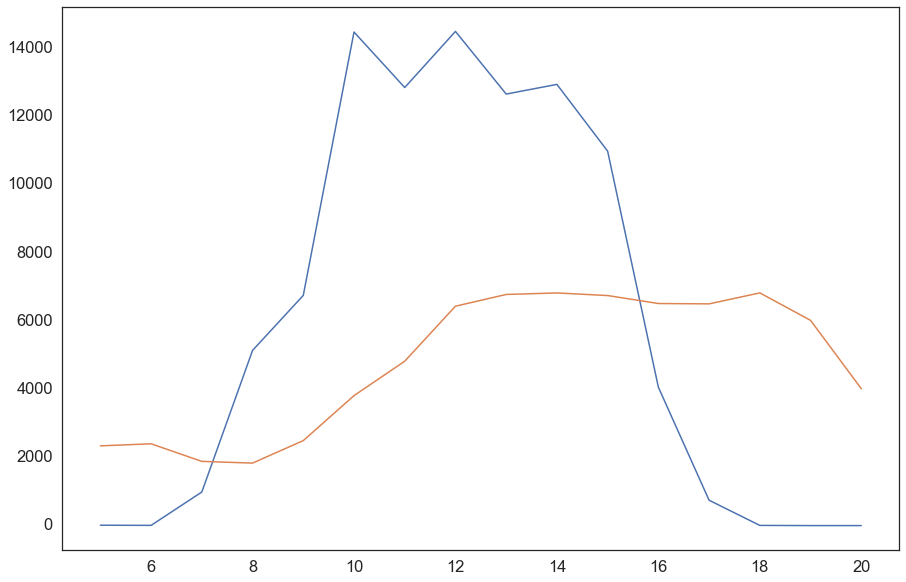

In [525]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(y_v2[32:48].index.hour, y_v2[32:48].values)
ax.plot(y_v2[32:48].index.hour, lr_val_preds[32:48])

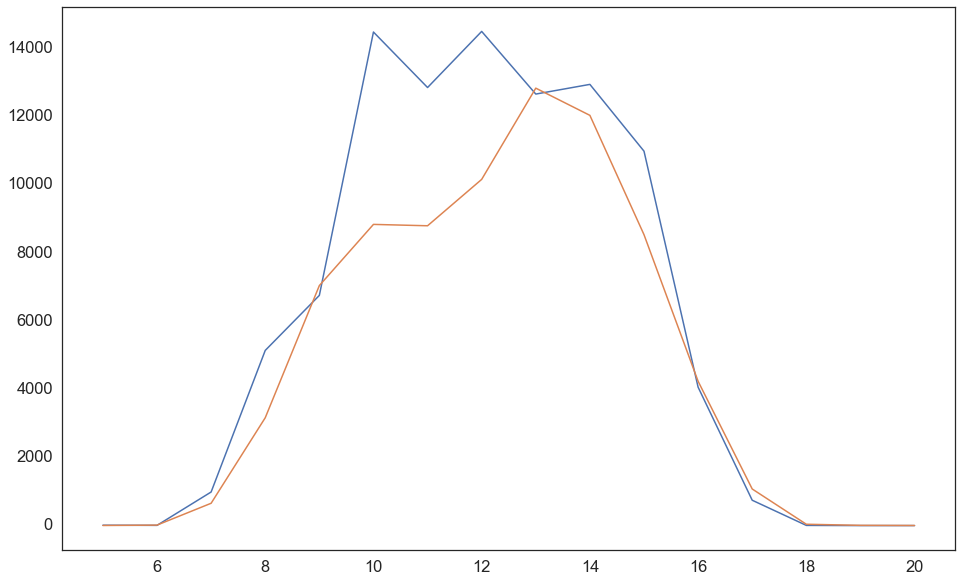

In [526]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(y_v[32:48].index.hour, y_v[32:48].values)
ax.plot(y_v[32:48].index.hour, val_preds[32:48])

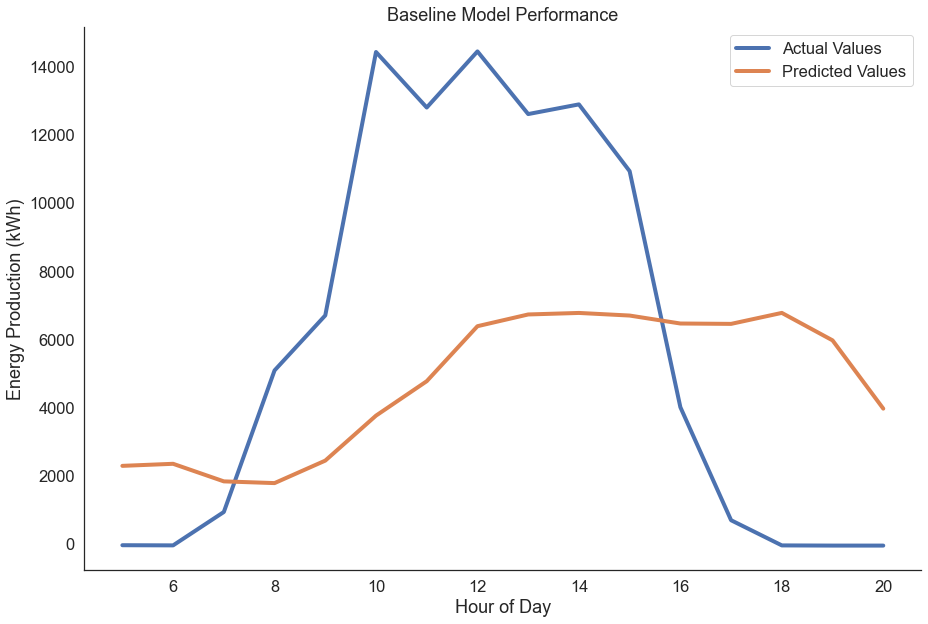

In [527]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

splot = sns.lineplot(y_v2[32:48].index.hour, y_v2[32:48].values, label='Actual Values', lw=4)
splot = sns.lineplot(y_v2[32:48].index.hour, lr_val_preds[32:48], label='Predicted Values', lw=4)
splot.set_title('Baseline Model Performance')
splot.set_xlabel('Hour of Day')
splot.set_ylabel('Energy Production (kWh)')
sns.despine()
# plt.savefig('../../report/figures/baseline_performance.png')

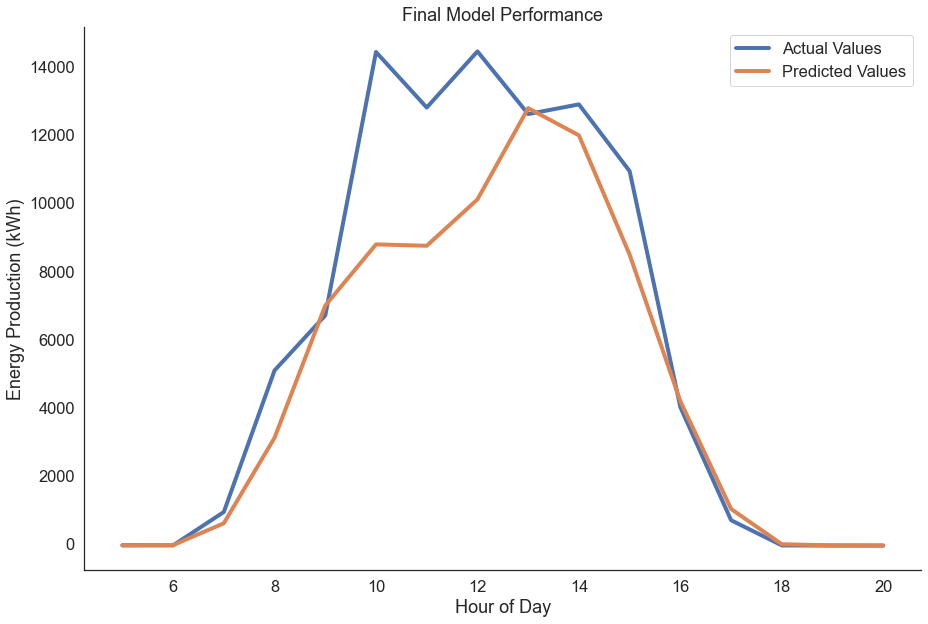

In [528]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

splot = sns.lineplot(y_v[32:48].index.hour, y_v[32:48].values, label='Actual Values', lw=4)
splot = sns.lineplot(y_v[32:48].index.hour, val_preds[32:48], label='Predicted Values', lw=4)
splot.set_title('Final Model Performance')
splot.set_xlabel('Hour of Day')
splot.set_ylabel('Energy Production (kWh)')
sns.despine()
# plt.savefig('../../report/figures/final_performance.png')

The above plots show the performance increase from the baseline model to the current best performing random forest regressor. Next I want to recreate the energy fluctuation plot showing how solar energy production changes with time.

In [529]:
daily_energy_mean = energy_daily.rolling(30).mean()

NameError: name 'energy_daily' is not defined

In [530]:
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(energy_daily, label='Original')
ax.plot(daily_energy_mean, label='Mean', color='red')
ax.legend(loc='best')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Energy Production (kWh)', fontsize=20)
ax.tick_params(which='major', labelsize= 18)

NameError: name 'energy_daily' is not defined

The last plot I want to make is to highlight the correlation between energy production and various weather conditions. I want to focus the plot on any weather conditions that have a pearson correlation magnitude above .2

In [531]:
df = pd.concat([energy, weather_hourly], axis=1)

In [532]:
df.head()

,nexus_meter,week,hour,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,,,,
2018-01-29 00:00:00,NaN,NaN,NaN,30.3425,28.0,30.0,92.25,29.5125,5.75,14.25,327.5,0.017317,80.0
2018-01-29 01:00:00,NaN,NaN,NaN,30.3400,28.0,30.0,92.00,29.5100,3.00,10.00,340.0,0.000000,80.0
2018-01-29 02:00:00,NaN,NaN,NaN,30.3300,28.0,30.0,92.00,29.5000,5.00,13.00,340.0,0.000000,80.0
2018-01-29 03:00:00,NaN,NaN,NaN,30.3300,28.0,30.0,92.00,29.5000,6.00,13.00,320.0,0.000000,80.0
2018-01-29 04:00:00,NaN,NaN,NaN,30.3300,28.0,30.0,92.50,29.5000,6.00,10.50,325.0,0.009066,80.0


In [533]:
df.drop(df[:'2018-01-29'].index, axis=0, inplace=True)

In [534]:
df.head()

,nexus_meter,week,hour,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,,,,
2018-01-30 00:00:00,0.0,5.0,0.0,30.46,14.0,17.0,88.0,29.63,10.0,6.0,310.0,0.0,0.0
2018-01-30 01:00:00,0.0,5.0,1.0,30.47,11.0,15.0,84.0,29.64,10.0,6.0,320.0,0.0,0.0
2018-01-30 02:00:00,0.0,5.0,2.0,30.47,11.0,14.0,88.0,29.64,10.0,5.0,330.0,0.0,0.0
2018-01-30 03:00:00,0.0,5.0,3.0,30.46,11.0,14.0,88.0,29.63,10.0,5.0,350.0,0.0,0.0
2018-01-30 04:00:00,0.0,5.0,4.0,30.45,10.0,13.0,88.0,29.62,10.0,0.0,0.0,0.0,0.0


In [535]:
df = df[(df.index.hour >= 5) & (df.index.hour <= 20)]

In [536]:
df.head()

,nexus_meter,week,hour,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
DATE,,,,,,,,,,,,,
2018-01-30 05:00:00,0.0,5.0,5.0,30.47,11.0,14.0,88.0,29.64,10.0,6.0,260.000000,0.0,0.0
2018-01-30 06:00:00,0.0,5.0,6.0,30.50,11.0,13.0,92.0,29.67,10.0,6.0,260.000000,0.0,0.0
2018-01-30 07:00:00,0.0,5.0,7.0,30.48,13.0,16.0,88.0,29.65,10.0,0.0,0.000000,0.0,0.0
2018-01-30 08:00:00,0.0,5.0,8.0,30.53,13.0,21.0,71.0,29.70,10.0,3.0,166.892929,0.0,0.0
2018-01-30 09:00:00,0.0,5.0,9.0,30.52,12.0,23.0,63.0,29.69,10.0,3.0,220.000000,0.0,0.0


In [537]:
df.corr()['nexus_meter']

nexus_meter                  1.000000
week                         0.035670
hour                        -0.065828
HourlyAltimeterSetting       0.053672
HourlyDewPointTemperature    0.165297
HourlyDryBulbTemperature     0.424767
HourlyRelativeHumidity      -0.677483
HourlyStationPressure        0.053479
HourlyVisibility             0.300541
HourlyWindSpeed              0.069730
HourlyWindDirection          0.076415
HourlyPrecipitation         -0.098451
cloud_coverage              -0.288953
Name: nexus_meter, dtype: float64

In [538]:
corr_values = df.corr()['nexus_meter'].values

In [539]:
corr_values_mag = [(-v) if v < 0 else v for v in corr_values]

In [540]:
feats = ['Week', 'Hour', 'Altimeter', 'Dew Point', 'Temperature', 'Humidity', 'Pressure', 'Visibility', 'Wind Speed', 'Wind Direction', 'Precipitation', 'Cloud Coverage']

In [541]:
corr_values_mag = corr_values_mag[1:]

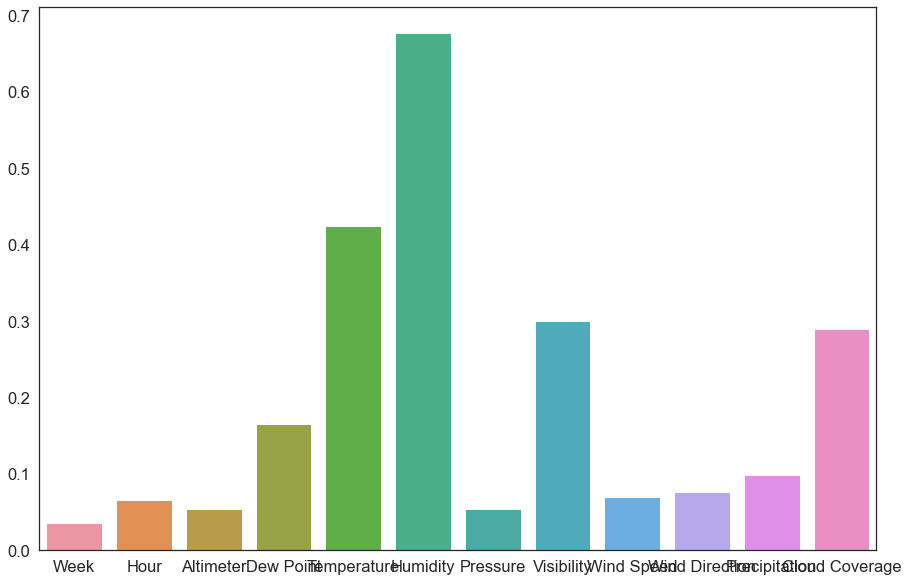

In [542]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

splot = sns.barplot(feats, corr_values_mag)

In [543]:
idxs = [4, 5, 7, 11]
corrs = []
for idx in idxs:
    corrs.append(corr_values_mag[idx])

In [544]:
corrs

[0.42476745448665904,
 0.6774833774729803,
 0.3005414371504727,
 0.288953148642086]

In [545]:
corrs_sorted = sorted(corrs)

In [546]:
corrs_sorted

[0.288953148642086,
 0.3005414371504727,
 0.42476745448665904,
 0.6774833774729803]

In [547]:
feats = ['Cloud Cover', 'Visibility', 'Temperature', 'Humidity']

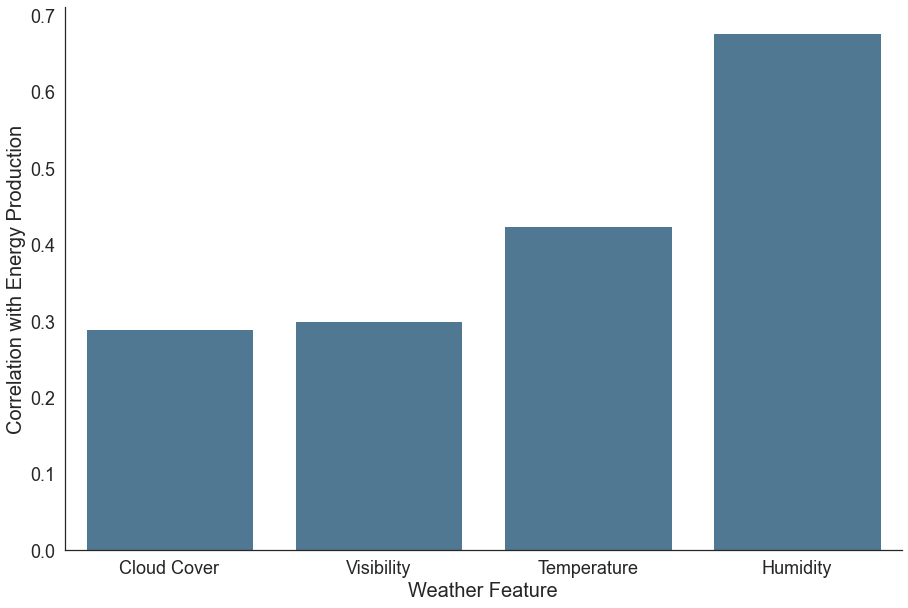

In [548]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_context({'figure.figsize': (15, 10)})

splot = sns.barplot(feats, corrs_sorted, color='#457b9d')
splot.set_xlabel('Weather Feature', fontsize=20)
splot.set_ylabel('Correlation with Energy Production', fontsize=20)
splot.tick_params(which='major', labelsize= 18)
sns.despine()

## Further Model Iterations and Feature Selection

To wrap up my MVP modeling I want to perform a few more tasks:
- Feature selection
- PCA to account for multicollinearity between features
- Continued model experimentation and hyperparameter tuning

To get a better idea of which features are most beneficial to the model, I want to utilize forward selection. This tries to optimize for adjusted r-squared by adding features one at a time until either the score goes down or we run out of features. I will utilize code found online. Code citation can be found in the function docstring.

In [549]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared

    Citation:
    Title: Forward Selection with statsmodels
    Author: Aaron Schumacher
    Data: 2015
    Availability: https://planspace.org/20150423-forward_selection_with_statsmodels/
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [550]:
model = forward_selected(train, 'nexus_meter')

In [551]:
model.model.formula

'nexus_meter ~ HourlyRelativeHumidity + hour + HourlyDewPointTemperature + HourlyStationPressure + HourlyDryBulbTemperature + HourlyWindDirection + cloud_coverage + HourlyWindSpeed + HourlyVisibility + week + HourlyAltimeterSetting + HourlyPrecipitation + 1'

In [552]:
model_df.corr()

,nexus_meter,week,hour,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindSpeed,HourlyWindDirection,HourlyPrecipitation,cloud_coverage
nexus_meter,1.000000,3.566984e-02,-6.582758e-02,0.125869,0.171686,0.286182,-0.337199,0.126060,0.232704,-0.021366,0.037090,-0.100807,-0.296493
week,0.035670,1.000000e+00,-4.139052e-18,-0.024004,0.270952,0.241965,0.022771,-0.023982,0.067546,-0.184562,-0.006153,-0.005399,-0.132506
hour,-0.065828,-4.139052e-18,1.000000e+00,-0.047209,0.049819,0.225828,-0.462852,-0.047639,0.162309,0.160316,0.067047,-0.011432,0.020685
HourlyAltimeterSetting,0.125869,-2.400447e-02,-4.720945e-02,1.000000,-0.424511,-0.348654,-0.142591,0.999906,0.115811,-0.244733,-0.061772,-0.133194,-0.215461
HourlyDewPointTemperature,0.171686,2.709523e-01,4.981902e-02,-0.424511,1.000000,0.914340,0.039491,-0.424559,0.064558,-0.214664,-0.102319,0.112365,-0.044925
HourlyDryBulbTemperature,0.286182,2.419647e-01,2.258276e-01,-0.348654,0.914340,1.000000,-0.360674,-0.348844,0.237265,-0.140622,-0.075771,0.027727,-0.190786
HourlyRelativeHumidity,-0.337199,2.277094e-02,-4.628523e-01,-0.142591,0.039491,-0.360674,1.000000,-0.142156,-0.514404,-0.154637,-0.058990,0.216588,0.389346
HourlyStationPressure,0.126060,-2.398206e-02,-4.763944e-02,0.999906,-0.424559,-0.348844,-0.142156,1.000000,0.115465,-0.244800,-0.062064,-0.133150,-0.215288
HourlyVisibility,0.232704,6.754618e-02,1.623087e-01,0.115811,0.064558,0.237265,-0.514404,0.115465,1.000000,0.034502,0.085877,-0.405151,-0.382977
HourlyWindSpeed,-0.021366,-1.845622e-01,1.603157e-01,-0.244733,-0.214664,-0.140622,-0.154637,-0.244800,0.034502,1.000000,0.235187,0.035029,0.202527


Since I have restructured my train_test_split, I think incorporating the past weather conditions and how they change may be useful for the model again. So I am going to recreate those features again here. Since I am adding more features, I want to drop a few of the ones that are multicollinear or that don't explain much of the variance in energy production. Pressure and altimeter setting have a correlation value of .99, so I will drop pressure since altimeter is slightly more correlated with nexus_meter. I also want to drop precipitation, wind speed, and wind direction since they do not explain much of the variance of the target value.

In [553]:
weather_hourly2 = weather_hourly.drop(['HourlyStationPressure', 'HourlyPrecipitation', 'HourlyWindSpeed', 'HourlyWindDirection'], axis=1)

In [554]:
weather_hourly2.head()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,cloud_coverage
DATE,,,,,,
2018-01-29 00:00:00,30.3425,28.0,30.0,92.25,5.75,80.0
2018-01-29 01:00:00,30.3400,28.0,30.0,92.00,3.00,80.0
2018-01-29 02:00:00,30.3300,28.0,30.0,92.00,5.00,80.0
2018-01-29 03:00:00,30.3300,28.0,30.0,92.00,6.00,80.0
2018-01-29 04:00:00,30.3300,28.0,30.0,92.50,6.00,80.0


Now I can create the lagged dataframe from the weather_hourly2 variable.

In [555]:
weather_lagged_df = weather_hourly2.shift(3)

In [556]:
weather_lagged_df.head()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,cloud_coverage
DATE,,,,,,
2018-01-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29 03:00:00,30.3425,28.0,30.0,92.25,5.75,80.0
2018-01-29 04:00:00,30.3400,28.0,30.0,92.00,3.00,80.0


Lagged dataframe is formatted correctly. Now I can drop the first three rows of both dataframes since the lagged dataframe is missing data and these rows are dropped when paired with the energy dataframe anyways. Once I drop these rows I will be able to create the weather change dataframe which gives the slope of each wheather condition over the three hour timeframe.

In [557]:
weather_hourly2.drop(weather_hourly2.iloc[:3].index, axis=0, inplace=True)
weather_lagged_df.drop(weather_lagged_df.iloc[:3].index, axis=0, inplace=True)

In [558]:
# create empty weather change df
weather_change_df = pd.DataFrame(index=weather_hourly2.index, columns=weather_hourly2.columns)

Now that I have the empty weather change dataframe, I can calculate the slope over the three hour lag for each weather condition using the following formula: (current value - past value)/3

In [559]:
for idx in weather_change_df.index:
    weather_change_df.loc[idx] = (weather_hourly2.loc[idx] - weather_lagged_df.loc[idx])/3

In [560]:
weather_change_df.head()

,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyVisibility,cloud_coverage
DATE,,,,,,
2018-01-29 03:00:00,-0.00416667,0,0,-0.0833333,0.0833333,0
2018-01-29 04:00:00,-0.00333333,0,0,0.166667,1,0
2018-01-29 05:00:00,0.00333333,-0.333333,0,-1.33333,1.66667,0
2018-01-29 06:00:00,0.01,-0.666667,-0.333333,-1,-0.333333,0
2018-01-29 07:00:00,0.0133333,-1,-0.583333,-1.91667,1,0


weather_change_df was created correctly. Before i merge these dataframes I want to change the column names so that I can differentiate between the dataframes.

In [561]:
weather_hourly2.columns = ['altimeter', 'dew_point', 'temp', 'humidity', 'visibility', 'cloud_coverage']
weather_lagged_df.columns = ['lag_altimeter', 'lag_dew_point', 'lag_temp', 'lag_humidity', 'lag_visibility', 'lag_cloud_coverage']
weather_change_df.columns = ['altimeter_change', 'dew_point_change', 'temp_change', 'humidity_change', 'visibility_change', 'cloud_coverage_change']

In [562]:
big_weather_df = pd.concat([weather_hourly2, weather_lagged_df, weather_change_df], axis=1)

In [563]:
big_weather_df.head()

,altimeter,dew_point,temp,humidity,visibility,cloud_coverage,lag_altimeter,lag_dew_point,lag_temp,lag_humidity,lag_visibility,lag_cloud_coverage,altimeter_change,dew_point_change,temp_change,humidity_change,visibility_change,cloud_coverage_change
DATE,,,,,,,,,,,,,,,,,,
2018-01-29 03:00:00,30.33,28.0,30.00,92.00,6.0,80.0,30.3425,28.0,30.0,92.25,5.75,80.0,-0.00416667,0,0,-0.0833333,0.0833333,0
2018-01-29 04:00:00,30.33,28.0,30.00,92.50,6.0,80.0,30.3400,28.0,30.0,92.00,3.00,80.0,-0.00333333,0,0,0.166667,1,0
2018-01-29 05:00:00,30.34,27.0,30.00,88.00,10.0,80.0,30.3300,28.0,30.0,92.00,5.00,80.0,0.00333333,-0.333333,0,-1.33333,1.66667,0
2018-01-29 06:00:00,30.36,26.0,29.00,89.00,5.0,80.0,30.3300,28.0,30.0,92.00,6.00,80.0,0.01,-0.666667,-0.333333,-1,-0.333333,0
2018-01-29 07:00:00,30.37,25.0,28.25,86.75,9.0,80.0,30.3300,28.0,30.0,92.50,6.00,80.0,0.0133333,-1,-0.583333,-1.91667,1,0


Before I combine this weather dataframe with energy, I need to drop the first three rows of the energy dataframe so the rows line up correctly.

In [564]:
energy2 = energy.drop(energy.iloc[:3].index, axis=0)

In [565]:
energy2.head()

,nexus_meter,week,hour
time,,,
2018-01-30 03:00:00,0.0,5,3
2018-01-30 04:00:00,0.0,5,4
2018-01-30 05:00:00,0.0,5,5
2018-01-30 06:00:00,0.0,5,6
2018-01-30 07:00:00,0.0,5,7


In [566]:
base_df2 = pd.concat([energy2, big_weather_df.shift(3)], axis=1)

In [567]:
base_df2.head()

,nexus_meter,week,hour,altimeter,dew_point,temp,humidity,visibility,cloud_coverage,lag_altimeter,...,lag_temp,lag_humidity,lag_visibility,lag_cloud_coverage,altimeter_change,dew_point_change,temp_change,humidity_change,visibility_change,cloud_coverage_change
DATE,,,,,,,,,,,,,,,,,,,,,
2018-01-29 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-29 06:00:00,NaN,NaN,NaN,30.33,28.0,30.0,92.0,6.0,80.0,30.3425,...,30.0,92.25,5.75,80.0,-0.00416667,0,0,-0.0833333,0.0833333,0
2018-01-29 07:00:00,NaN,NaN,NaN,30.33,28.0,30.0,92.5,6.0,80.0,30.3400,...,30.0,92.00,3.00,80.0,-0.00333333,0,0,0.166667,1,0


The first day does not contain any energy data so I will drop the rest of those rows

In [568]:
base_df2.drop(base_df2[:'2018-01-29'].index, axis=0, inplace=True)

I am focusing my model on the times between 5am and 8pm because these are the times energy is being produced, so I will now subset the dataframe to onlu include these times

In [569]:
model_df2 = base_df2[(base_df2.index.hour >= 5) & (base_df2.index.hour <= 20)]

In [570]:
model_df2.isna().sum()

nexus_meter              0
week                     0
hour                     0
altimeter                0
dew_point                0
temp                     0
humidity                 0
visibility               0
cloud_coverage           0
lag_altimeter            9
lag_dew_point            9
lag_temp                 9
lag_humidity             9
lag_visibility           9
lag_cloud_coverage       9
altimeter_change         9
dew_point_change         9
temp_change              9
humidity_change          9
visibility_change        9
cloud_coverage_change    9
dtype: int64

I need to impute the few rows that are missing data, I will continue to use IterativeImputer for that. I need to remove 'nexus_meter' when imputing so this value is not taken into account when filling the missing data as this would ruin my modeling results.

In [571]:
model2_imputed = imp.fit_transform(model_df2.drop('nexus_meter', axis=1))

In [572]:
model2_df = pd.DataFrame(index=model_df2.index, columns=model_df2.drop('nexus_meter', axis=1).columns, data=model2_imputed)

In [573]:
model2_df['nexus_meter'] = model_df2['nexus_meter']

Great now the modeling dataframe is all set up, I can perform a train, validation, and test split with the same indices I used earlier.

In [574]:
train2 = model2_df.iloc[:10000]
val2 = model2_df.iloc[10000:12224]
test2 = model2_df.iloc[12224:]

In [575]:
# separate target and features

# train
X_train2 = train2.drop('nexus_meter', axis=1)
y_train2 = train2['nexus_meter']

# validation
X_val2 = val2.drop('nexus_meter', axis=1)
y_val2 = val2['nexus_meter']

# testing
X_test2 = test2.drop('nexus_meter', axis=1)
y_test2 = test2['nexus_meter']

## Model Iterations with new features

I want to begin with the random forest model

In [576]:
# scale training data
X_train2_std_scale = scaler.fit_transform(X_train2)

In [577]:
rf2 = RandomForestRegressor(random_state=42, max_depth=15, min_samples_split=10, min_samples_leaf=2)

In [578]:
# RMSE over five splits on training data with new features
(np.sqrt(cross_val_score(rf2, X_train2_std_scale, y_train2, scoring=mse_score, cv=5))).mean()

In [502]:
# RMSE over five splits on training data with original features
(np.sqrt(cross_val_score(rf2, X_t_scaled, y_t, scoring=mse_score, cv=5))).mean()

2679.033540982774

### Gradient Boosting

In [503]:
gb = GradientBoostingRegressor(random_state=42, max_depth=5, n_estimators=500, min_samples_leaf=150, min_impurity_decrease=.5, min_samples_split=300)

In [504]:
# RMSE over five splits on training data with new features
(np.sqrt(cross_val_score(gb, X_train2_std_scale, y_train2, scoring=mse_score, cv=5))).mean()

2634.293886954528

In [506]:
 # RMSE over five splits on training data with original features
(np.sqrt(cross_val_score(gb, X_t_scaled, y_t, scoring=mse_score, cv=5))).mean()

2629.073440785317

It actually seems like the original features are performing better, so I am going to continue with those. I need to keep in mind that without the solar irradiance the weather variables won't be entirely accurate. The next iteration of the project will include solar irradiance and I expect model performance to increase significantly. For now I want to run two more grid searches, one for random forest and one for gradient boosting, including more hyperparameters in the search.

### Random Forest Grid Search

In [508]:
params = {'n_estimators': [50, 250, 500],
            'max_depth': [2, 5, 8, 10, 12, 15, 20],
            'min_samples_split': [4, 5, 10, 20, 25, 100, 200],
            'min_samples_leaf': [2, 5, 10, 25, 50, 100],
            'min_impurity_decrease': [0.0, 0.1, 0.25, 0.5, 0.6, 0.75]}

In [ ]:
rf3 = RandomForestRegressor(random_state=42)

In [511]:
gs2 = GridSearchCV(rf3, param_grid=params, scoring='neg_mean_squared_error')